In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import InterpolationMode
from read_data import HRDataset, BicubicDownsample, plot_lr_hr_comparison
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Read data

In [2]:
train_path = r"/Users/alan/Documents/SR task/data/DIV2K_train_HR"
val_path = r"/Users/alan/Documents/SR task/data/DIV2K_valid_HR"

In [3]:
class SRPatchDataset(Dataset):
    def __init__(self, hr_dataset, scale=4, patch_size=256, random_crop=True):
        self.hr_dataset = hr_dataset
        self.scale = scale
        self.patch_size = patch_size
        self.random_crop = random_crop

        if patch_size % 4 != 0:
            raise ValueError('patch_size must be divisible by 4 for this autoencoder.')

    def __len__(self):
        return len(self.hr_dataset)

    def _crop(self, hr):
        w, h = hr.size
        ps = min(self.patch_size, w, h)
        ps = ps - (ps % 4)

        if self.random_crop:
            top = torch.randint(0, h - ps + 1, (1,)).item()
            left = torch.randint(0, w - ps + 1, (1,)).item()
        else:
            top = (h - ps) // 2
            left = (w - ps) // 2

        return TF.crop(hr, top, left, ps, ps)

    def __getitem__(self, idx):
        hr = self.hr_dataset[idx]
        hr = self._crop(hr)

        w, h = hr.size
        lr = hr.resize((w // self.scale, h // self.scale), Image.BICUBIC)
        lr_up = lr.resize((w, h), Image.BICUBIC)

        lr_t = TF.to_tensor(lr_up)
        hr_t = TF.to_tensor(hr)
        return lr_t, hr_t


train_ds_hr = HRDataset(train_path)
val_ds_hr = HRDataset(val_path)

patch_size = 256
scale = 4
train_ds_lr = SRPatchDataset(train_ds_hr, scale=scale, patch_size=patch_size, random_crop=True)
val_ds_lr = SRPatchDataset(val_ds_hr, scale=scale, patch_size=patch_size, random_crop=False)


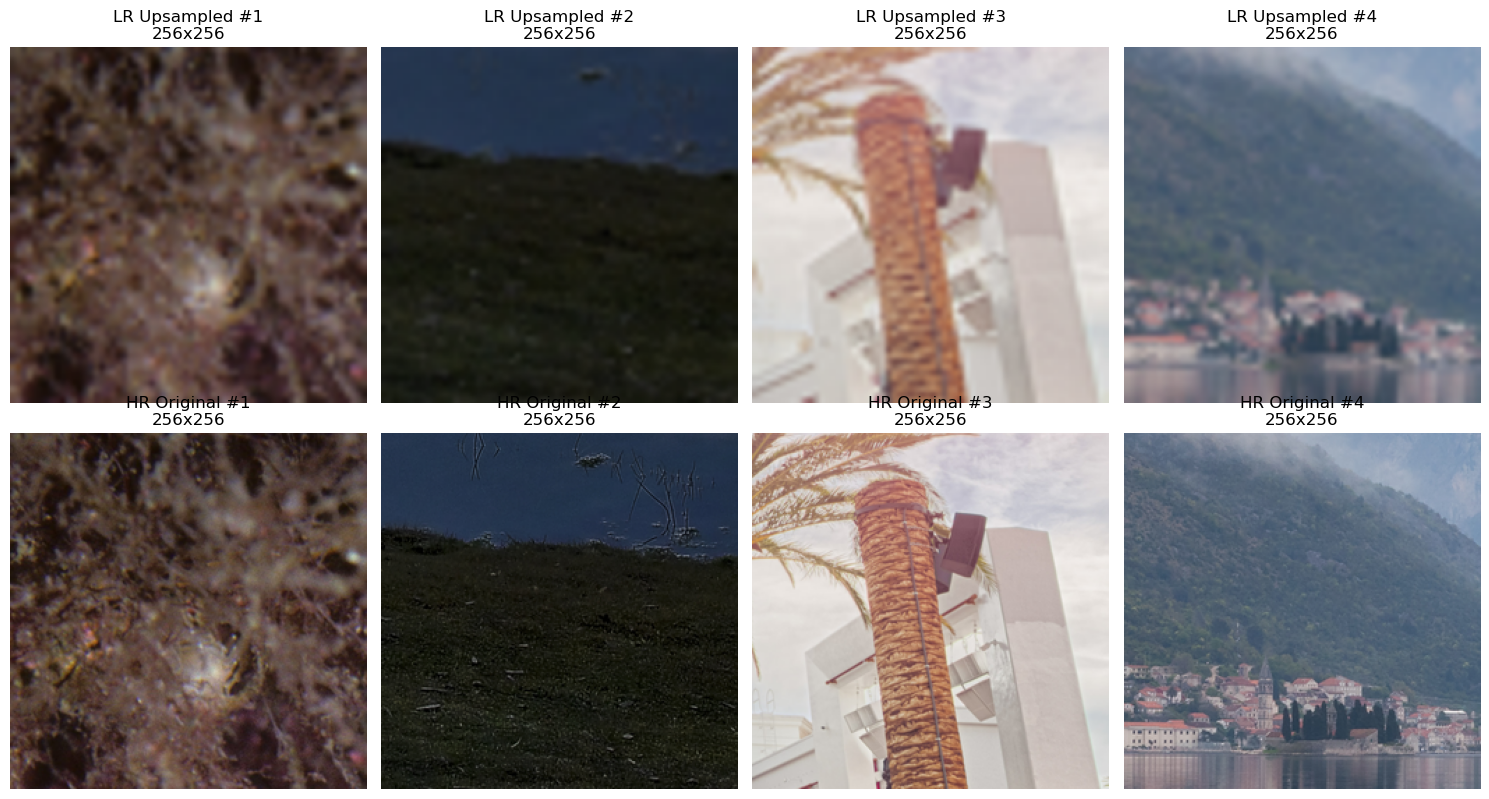

In [4]:
plot_lr_hr_comparison(train_ds_lr, num_samples=4)

# Prepare for modeling

In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [6]:
batch_size = 4
pin_memory = (device.type == 'cuda')

train_loader = DataLoader(train_ds_lr, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=pin_memory)
val_loader = DataLoader(val_ds_lr, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)

sample_lr, sample_hr = next(iter(train_loader))
sample_lr.shape, sample_hr.shape


(torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256]))

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class AutoencoderSR(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = ConvBlock(3, 64)
        self.enc2 = ConvBlock(64, 128, s=2)
        self.enc3 = ConvBlock(128, 256, s=2)

        self.bottleneck = nn.Sequential(
            ConvBlock(256, 256),
            ConvBlock(256, 256),
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.dec1 = ConvBlock(128, 128)

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.dec2 = ConvBlock(64, 64)

        self.out_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x

        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)

        x = self.bottleneck(x)

        x = self.up1(x)
        x = self.dec1(x)

        x = self.up2(x)
        x = self.dec2(x)

        x = self.out_conv(x)
        x = torch.sigmoid(x + residual)
        return x


model = AutoencoderSR().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

sum(p.numel() for p in model.parameters())


2395075

In [8]:
@torch.no_grad()
def evaluate_psnr(model, loader, device):
    model.eval()
    mse_sum = 0.0
    count = 0

    for lr, hr in loader:
        lr = lr.to(device)
        hr = hr.to(device)
        pred = model(lr)

        mse = torch.mean((pred - hr) ** 2, dim=(1, 2, 3))
        mse_sum += mse.sum().item()
        count += mse.numel()

    avg_mse = mse_sum / max(count, 1)
    psnr = 10.0 * torch.log10(torch.tensor(1.0) / torch.tensor(avg_mse + 1e-12))
    return psnr.item()


In [9]:
epochs = 5
history = {'train_loss': [], 'val_psnr': []}

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', leave=False)
    for lr, hr in pbar:
        lr = lr.to(device, non_blocking=(device.type == 'cuda'))
        hr = hr.to(device, non_blocking=(device.type == 'cuda'))

        optimizer.zero_grad(set_to_none=True)
        pred = model(lr)
        loss = criterion(pred, hr)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=f'{loss.item():.4f}')

    train_loss = running_loss / len(train_loader)
    val_psnr = evaluate_psnr(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_psnr'].append(val_psnr)

    print(f'Epoch {epoch:02d}: train_loss={train_loss:.4f}, val_psnr={val_psnr:.2f} dB')


Epoch 1/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 01: train_loss=0.1000, val_psnr=19.60 dB


Epoch 2/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 02: train_loss=0.0786, val_psnr=21.35 dB


Epoch 3/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 03: train_loss=0.0719, val_psnr=21.58 dB


Epoch 4/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 04: train_loss=0.0706, val_psnr=21.62 dB


Epoch 5/5:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 05: train_loss=0.0671, val_psnr=21.85 dB


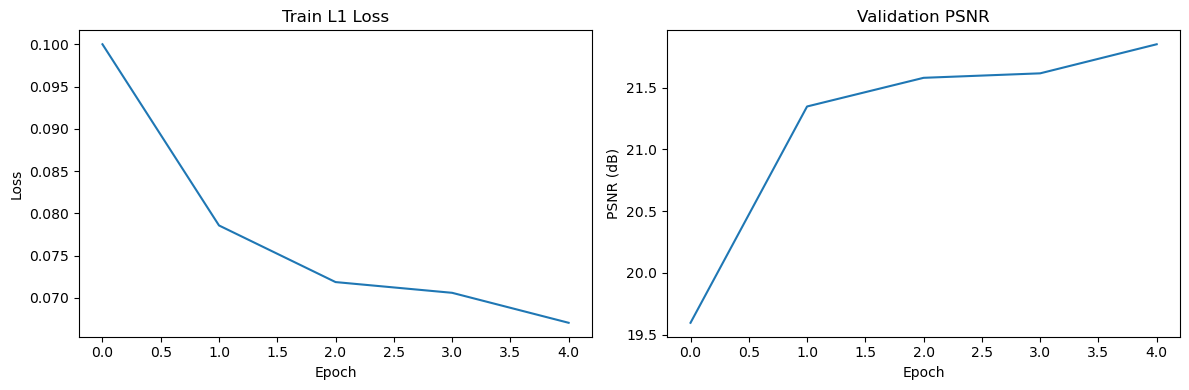

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Train L1 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_psnr'])
plt.title('Validation PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')

plt.tight_layout()
plt.show()


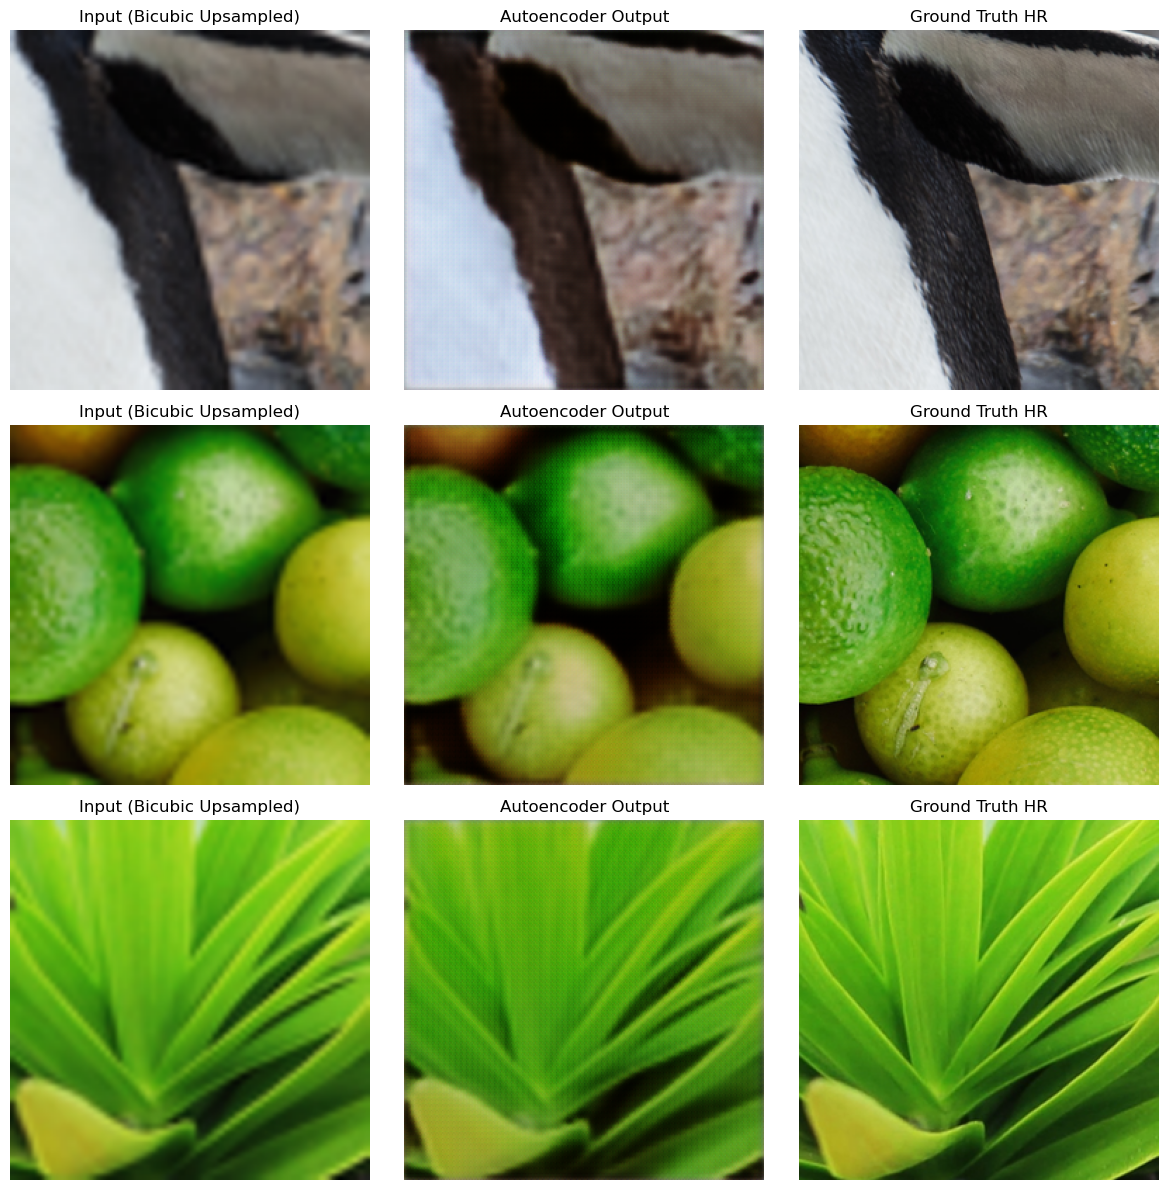

In [11]:
@torch.no_grad()
def show_predictions(model, dataset, n=3):
    model.eval()
    n = min(n, len(dataset))

    fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))
    if n == 1:
        axes = axes[None, :]

    for i in range(n):
        lr, hr = dataset[i]
        pred = model(lr.unsqueeze(0).to(device)).squeeze(0).cpu()

        axes[i, 0].imshow(lr.permute(1, 2, 0).numpy())
        axes[i, 0].set_title('Input (Bicubic Upsampled)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred.permute(1, 2, 0).numpy())
        axes[i, 1].set_title('Autoencoder Output')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(hr.permute(1, 2, 0).numpy())
        axes[i, 2].set_title('Ground Truth HR')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


show_predictions(model, val_ds_lr, n=3)


In [12]:
#torch.save(model.state_dict(), 'autoencoder_sr_div2k.pt')
#print('Saved model weights to autoencoder_sr_div2k.pt')


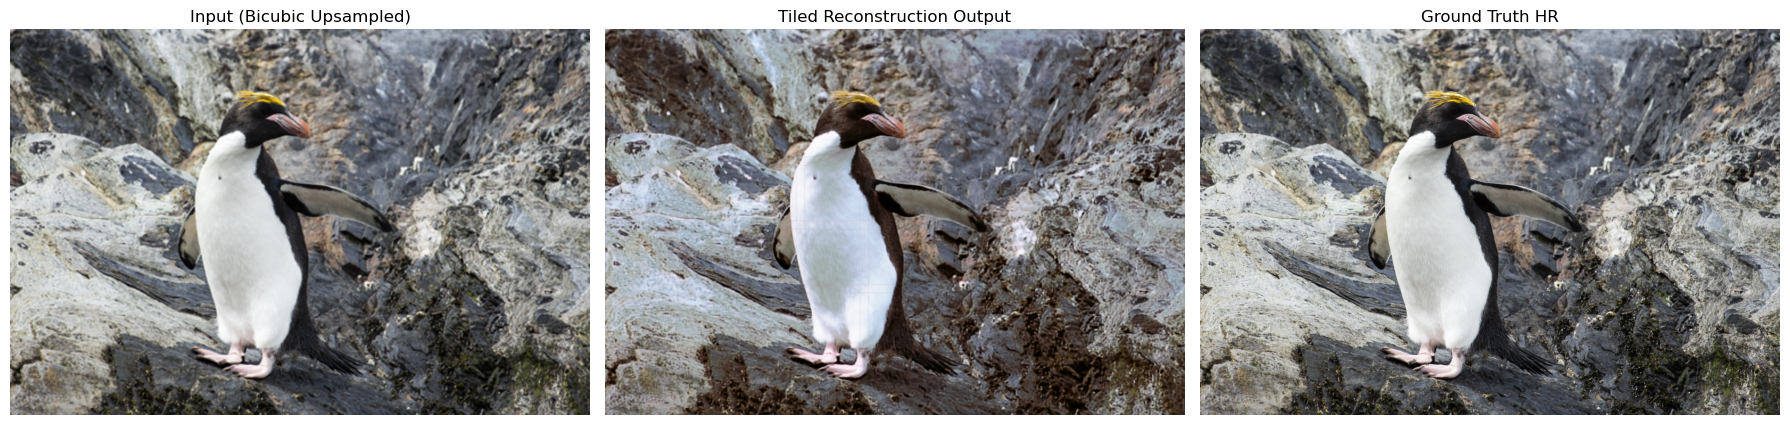

In [13]:
@torch.no_grad()
def tiled_inference(model, lr_t, device, tile_size=256, overlap=32):
    """
    lr_t: [3, H, W] (already bicubic-upsampled to HR size)
    return: [3, H, W]
    """
    model.eval()

    if overlap >= tile_size:
        raise ValueError('overlap must be smaller than tile_size')

    _, H, W = lr_t.shape
    stride = tile_size - overlap

    ys = list(range(0, max(H - tile_size, 0) + 1, stride))
    xs = list(range(0, max(W - tile_size, 0) + 1, stride))
    if len(ys) == 0 or ys[-1] != H - tile_size:
        ys.append(max(H - tile_size, 0))
    if len(xs) == 0 or xs[-1] != W - tile_size:
        xs.append(max(W - tile_size, 0))

    out = torch.zeros((3, H, W), dtype=lr_t.dtype)
    weight = torch.zeros((1, H, W), dtype=lr_t.dtype)

    for y in ys:
        for x in xs:
            patch = lr_t[:, y:y + tile_size, x:x + tile_size]

            ph, pw = patch.shape[-2:]
            if ph < tile_size or pw < tile_size:
                pad_h = tile_size - ph
                pad_w = tile_size - pw
                patch = torch.nn.functional.pad(patch, (0, pad_w, 0, pad_h), mode='reflect')

            pred = model(patch.unsqueeze(0).to(device)).squeeze(0).cpu()
            pred = pred[:, :ph, :pw]

            out[:, y:y + ph, x:x + pw] += pred
            weight[:, y:y + ph, x:x + pw] += 1.0

    out = out / weight.clamp_min(1e-8)
    return out.clamp(0, 1)


# Demo: reconstruct one full validation image from tiled patches
idx = 0
hr_img = val_ds_hr[idx]
w, h = hr_img.size
lr_img = hr_img.resize((w // scale, h // scale), Image.BICUBIC)
lr_up = lr_img.resize((w, h), Image.BICUBIC)

lr_t = TF.to_tensor(lr_up)
hr_t = TF.to_tensor(hr_img)
pred_t = tiled_inference(model, lr_t, device=device, tile_size=256, overlap=32)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(lr_t.permute(1, 2, 0).numpy())
axes[0].set_title('Input (Bicubic Upsampled)')
axes[0].axis('off')

axes[1].imshow(pred_t.permute(1, 2, 0).numpy())
axes[1].set_title('Tiled Reconstruction Output')
axes[1].axis('off')

axes[2].imshow(hr_t.permute(1, 2, 0).numpy())
axes[2].set_title('Ground Truth HR')
axes[2].axis('off')
plt.tight_layout()
plt.show()
